In [10]:
import xml.etree.ElementTree as ET
from pymongo import UpdateOne
from pymongo import MongoClient
from pymongo.errors import PyMongoError
import matplotlib.pyplot as plt


# Provide the db credentials for your machine
db_config = {
    'host': 'localhost',
    'port': 27017,
    'database': 'ubuntu8'
}
# Define the subset of tags
subset_tags = ['command-line', 'boot', 'networking', 'apt', 'drivers']

data_directory = 'C:\\Users\\mr2714\\OneDrive - rit.edu\\Python_Projects\\BigData\\data\\'

chunk_size = 5

print("hello")

hello


In [2]:
def connect():
    """
    Make the connection with the database and return the connection. 
    
    :returns a database client object.
    """
    try:
        # create a mongodb connection using the db_config provided in globals.py
        client = MongoClient(host=db_config['host'], 
                         port=db_config['port'])
        return client[db_config['database']]
    except PyMongoError as e:
        print(f"Error connecting to MongoDB: {e}")
        return None

In [40]:
import math

def clean_collection(collection_name):
    """
    clean the collection (drop collection) for fresh subset of the record. 

    :params collection_name: the input name of the collection to clean. 
    """
    # make a database connection
    db = connect()
    # get a list of database connection names
    collections = db.list_collection_names()
    # iterate over collections and drop each and print a message on console.
    for coll_name in collections:
        if coll_name == collection_name:
            db[coll_name].drop()
            print(f"Deleted collection: {coll_name}")

def create_centroids(K, T):
    """
    This method create a collection centriods, using K centroids for T tag.
    
    :params K: the number of samples (count) for centroids. 
    :params T: the name of the tag to take samples from kmposts. 
    """
    # first clean up the collection, 'centroids'
    clean_collection('centroids')
    # connect to the database
    db = connect()
    # take the posts collection to read data from
    posts_collection = db["kmposts"]
    # take the kmposts to write data as subset with matching tags
    centroid_collection = db['centroids']
    # set centroid for each K starting from 1
    centeroid = 1 
    # get a sample from tag, K, T set in globals.py
    subset_query = [
        # first match documents with a tag
        { "$match": {"Tags": {"$in": [T]}} },
        # then select sample of size K, set in globals.py
        {"$sample": {"size": K}}
    ]
    chunk_data = list(posts_collection.aggregate(subset_query))
    # create a list to hold all insert operations
    bulk_operations = []
    for doc in chunk_data:
        operation = {
            "_id": centeroid,
            "kmeansNorm": doc["kmeansNorm"]
        }
        bulk_operations.append(operation)
        # move to next sample 
        centeroid += 1
    # insert into centroids collection, 1...K
    if bulk_operations:
        centroid_collection.insert_many(bulk_operations)

# Function to calculate Euclidean distance between two vectors

def update_tag_cluster(kmposts_collection, centroid_collection, T):
    """
    This method updates the cluster value based on centriods, for T tag.
    
    :params kmposts_collectionK: the posts collection to find tags data and update clusters based on closeness. 
    :params centroid_collection: the centroid collection to find distances from. 
    :params T: the name of the tag to take samples from kmposts. 
    """
    sse = 0
    # Get the centroids data
    centroids = list(centroid_collection.find())
    centroid_norms = {c["_id"]: c["kmeansNorm"] for c in centroids}
    
    # Query posts with the given tag
    subset_query = [{ "$match": {"Tags": {"$in": [T]}} }]
    chunk_data = list(kmposts_collection.aggregate(subset_query))
    
    bulk_operations = []
    for doc in chunk_data:
        doc_norm = doc["kmeansNorm"]
        min_distance = float("inf")
        closest_centroid = 0
        
        # Calculate distance from each centroid
        for _id, norm in centroid_norms.items():
            dist = math.sqrt((norm[0] - doc_norm[0]) ** 2 + (norm[1] - doc_norm[1]) ** 2)
            if dist < min_distance:
                min_distance = dist
                closest_centroid = _id
        
        # Add the squared distance to SSE
        sse += min_distance ** 2
        
        # Prepare update for the post
        operation = UpdateOne(
            {"_id": doc["_id"]},
            {"$set": {"cluster": closest_centroid}}
        )
        bulk_operations.append(operation)
    
    # Execute the bulk update for posts
    try:
        kmposts_collection.bulk_write(bulk_operations)
        return sse
    except Exception as e:
        print(f"Error in bulk update: {e}")
        return None


def update_centroids(kmposts_collection, centroid_collection):
    """
    This method updates the centroid values after an iteration of cluster updates.
    
    :params kmposts_collectionK: the posts collection to find tags data and update clusters based on closeness. 
    :params centroid_collection: the centroid collection to find distances from. 
    """
    # get the centroids data
    centroids = list(centroid_collection.find())
    # get centroid norms with ids for mapping
    centroid_norms = {c["_id"]: c["kmeansNorm"] for c in centroids}
    # create a list to hold all update operations
    bulk_operations = []
    # iterate over centroids
    for _id, norm in centroid_norms.items():
        # find posts with each cluster
        cluster_docs = list(kmposts_collection.find({"cluster": _id}))
        # get sum norm as length of centroids
        sum_norms = [0] * len(norm)
        # calculate the new centroid by averaging the kmeansNorms
        for doc in cluster_docs:
            for i in range(len(doc["kmeansNorm"])):
                sum_norms[i] += doc["kmeansNorm"][i]
        # find the average 
        num_docs_in_cluster = len(cluster_docs)
        if num_docs_in_cluster > 0:
            # Calculate the new centroid by averaging the norms
            new_centroid = [x / num_docs_in_cluster for x in sum_norms]
        else:
            # If no documents are assigned to this centroid, keep the old centroid
            new_centroid = norm

        # prepare the new centroid document for bulk update
        operation = UpdateOne(
            {"_id": _id},
            {"$set": {"kmeansNorm": new_centroid}}
        )
        bulk_operations.append(operation)
    # Execute the bulk update for centroid recalculation
    try:
        centroid_collection.bulk_write(bulk_operations)
        print("Centroids updated successfully.")
    except Exception as e:
        print(f"Error in bulk update: {e}")

boot
Deleted collection: centroids
iteration 0
Centroids updated successfully.
sse_previous  inf
sse_new  0.842968772784542
diff  inf
iteration 1
Centroids updated successfully.
sse_previous  0.842968772784542
sse_new  0.7122289726924046
diff  0.13073980009213737
iteration 2
Centroids updated successfully.
sse_previous  0.7122289726924046
sse_new  0.6988553008778896
diff  0.013373671814514987
iteration 3
Centroids updated successfully.
sse_previous  0.6988553008778896
sse_new  0.698505182126057
diff  0.00035011875183266206
k=10, SSE=0.698505182126057
Deleted collection: centroids
iteration 0
Centroids updated successfully.
sse_previous  inf
sse_new  0.7261538962026691
diff  inf
iteration 1
Centroids updated successfully.
sse_previous  0.7261538962026691
sse_new  0.5807167876782044
diff  0.14543710852446468
iteration 2
Centroids updated successfully.
sse_previous  0.5807167876782044
sse_new  0.4536472794342487
diff  0.12706950824395574
iteration 3
Centroids updated successfully.
sse_pre

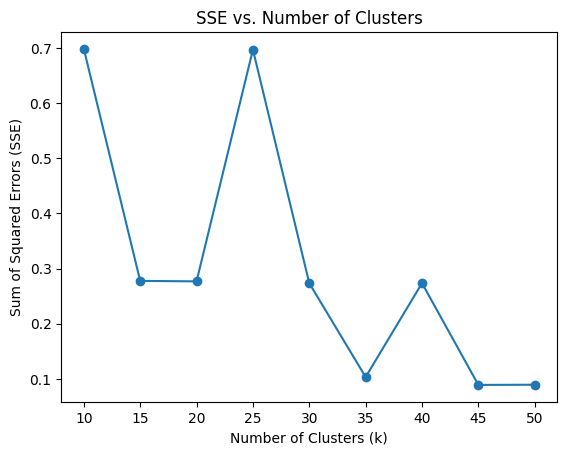

In [43]:
for T in ['boot']:
# for T in subset_tags:
    min_k=10
    step=5
    max_k=51
    max_iterations=100
    print(T)
    
    db = connect()
    kmposts_collection = db["kmposts"]
    centroid_collection = db["centroids"]
    sse_values = []
    for k in range(min_k, max_k, step):
        # first we create fresh centroids for each k with Tag T.
        create_centroids(k, T)
        
        sse_previous = float("inf")
        for iteration in range(max_iterations):
            print('iteration', iteration)
            # Run one iteration of K-means
            sse = update_tag_cluster(kmposts_collection, centroid_collection, T)
        #     # Update centroids
            centroids = update_centroids(kmposts_collection, centroid_collection)
            print('sse_previous ', sse_previous)
            print('sse_new ', sse)
            print('diff ', sse_previous - sse)
            # Check for convergence (SSE has stabilized)
            if abs(sse_previous - sse) < 1e-3:  # Convergence condition
                break
            sse_previous = sse

        sse_values.append(sse)
        print(f"k={k}, SSE={sse}")


    # # Plot the Sum of Squared Errors (SSE) vs. k
    ks = list(range(min_k, max_k, step))
    if not sse_values:
        print("Error: sse_values is empty. Ensure SSE values are calculated.")
    else:
        # Check alignment of ks and sse_values
        if len(ks) != len(sse_values):
            print(f"Error: Length mismatch - ks: {len(ks)}, sse_values: {len(sse_values)}")
        else:
            # Plot the Sum of Squared Errors (SSE) vs. k
            plt.plot(ks, sse_values, marker='o')
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Sum of Squared Errors (SSE)')
            plt.title('SSE vs. Number of Clusters')
            plt.show()

In [2]:
import time

one = 1
two = 2
for i in range(10):
    time.sleep(2)
    # Print on the same line and overwrite the previous output
    print(f'Iteration {i + 1} of {10}, sse: {one}, conv_val: {two}', end="\r")
